In [1]:
from sys import stdout
import hoggormplot as hop

import matplotlib.pyplot as plt
import hoggorm as ho
from hoggorm.cross_val import LeaveOneOut
from hoggorm import cross_val
import pandas as pd
import numpy as np
import os
from scipy.signal import savgol_filter
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def load_dir_csv(directory):
    csv_files = sorted( [ f for f in os.listdir(directory) if f.endswith(".txt") ])    
    csv_vars  = [ filename[:-4] for filename in csv_files ]
    gdict = globals()
    for filename, var in zip( csv_files, csv_vars ):
        print(f"{var:32s} = pd.read_csv({directory}/{filename})")
        gdict[var] = pd.read_csv( f"{directory}/{filename}" )
        print(f"{'nb of cols ':32s} = " + str(len(gdict[var])))
        display(gdict[var].head())

load_dir_csv("C:\Python")

Dataset                          = pd.read_csv(C:\Python/Dataset.txt)
nb of cols                       = 44


,Sample,AZM,CLT,AZD,CLTD,190,191,192,193,194,...,391,392,393,394,395,396,397,398,399,400
0,Cal_01,20.2,6.72,2.50,0.78,3.308227,3.395121,3.455562,3.527321,3.583758,...,-0.027220,-0.027028,-0.027514,-0.026277,-0.027345,-0.027892,-0.027767,-0.029429,-0.028922,-0.029249
1,Cal_02,20.2,3.36,0.00,1.56,2.819046,2.877378,2.911882,2.955613,2.987735,...,-0.024256,-0.023938,-0.024400,-0.023415,-0.024400,-0.024742,-0.024417,-0.026030,-0.025613,-0.025715
2,Cal_03,10.1,3.36,5.00,0.39,2.450861,2.542018,2.612755,2.693547,2.757591,...,-0.024619,-0.024490,-0.024533,-0.023579,-0.024672,-0.025005,-0.024939,-0.026406,-0.025882,-0.026129
3,Cal_04,10.1,10.08,1.25,1.56,2.291964,2.337271,2.365906,2.409659,2.443504,...,-0.030497,-0.030178,-0.030692,-0.029416,-0.030517,-0.031035,-0.030977,-0.032769,-0.032118,-0.032387
4,Cal_05,30.3,5.04,5.00,0.78,4.657196,4.793256,4.890508,4.999354,5.085045,...,-0.032035,-0.031919,-0.032341,-0.031012,-0.032220,-0.032906,-0.032601,-0.034688,-0.034138,-0.034492


In [3]:
Dataset.set_index('Sample', inplace=True)

In [4]:
X=Dataset.loc['Cal_01':'Cal_25', '190':'350']
y=Dataset.loc['Cal_01':'Cal_25', 'AZM':'CLTD']
Xv=Dataset.loc['Val_1':'Val_19', '190':'350']
yv=Dataset.loc['Val_1':'Val_19', 'AZM':'CLTD']
# Samples names
Xsamples=Dataset.index[:25]
Xsamples=list(Xsamples)
Xvsamples=Dataset.index[25:]
Xvsamples=list(Xvsamples)
#Analytes
Analytes=np.array(list(Dataset)[:4])
Analytes=list(Analytes)
# Define wavelength range
wl=np.array(list(X))
wl=list(wl)
X=np.array(X)
y=np.array(y)

In [5]:
# Calculate derivatives
X1 = savgol_filter(X, 11, polyorder = 2, deriv=1)
X2 = savgol_filter(X, 13, polyorder = 2,deriv=2)
Xv1 = savgol_filter(Xv, 11, polyorder = 2, deriv=1)
Xv2 = savgol_filter(Xv, 13, polyorder = 2,deriv=2)

In [6]:
modelD0 = ho.pcr.nipalsPCR(arrX=X, Xstand=False, arrY=y, Ystand=False,cvType=["loo"], numComp=6)

loo


In [7]:
modelD1 = ho.pcr.nipalsPCR(arrX=X1, Xstand=False, arrY=y, Ystand=False,cvType=["loo"], numComp=6)

loo


In [8]:
modelD2 = ho.pcr.nipalsPCR(arrX=X2, Xstand=False, arrY=y, Ystand=False,cvType=["loo"], numComp=6)

loo


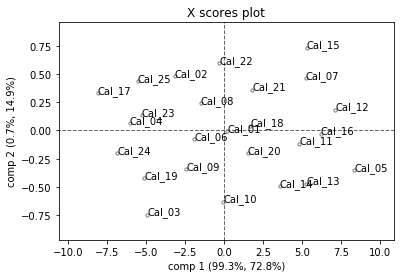

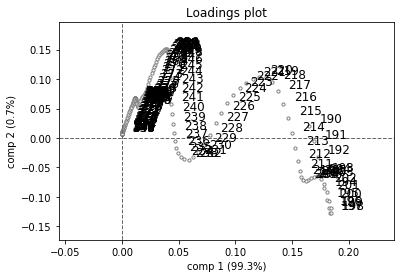

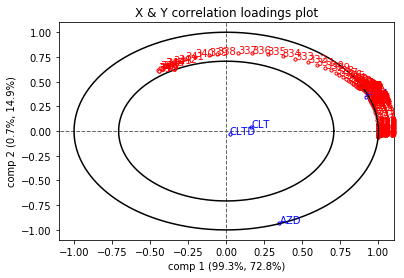

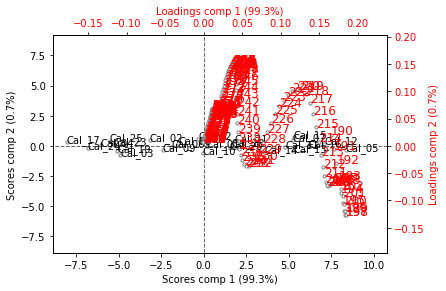

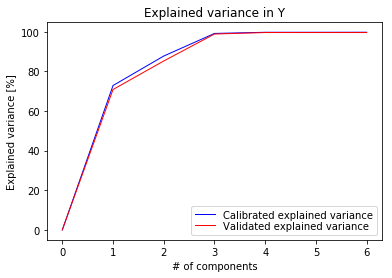

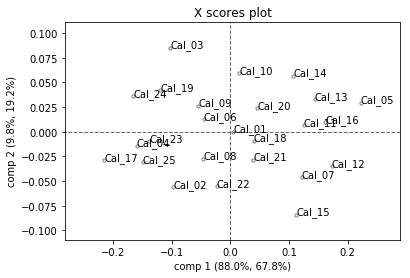

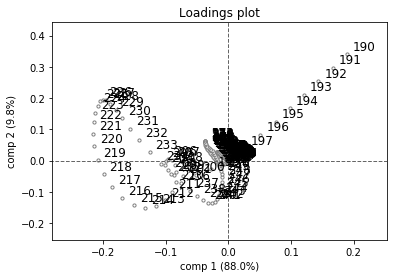

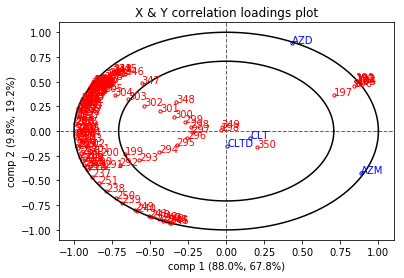

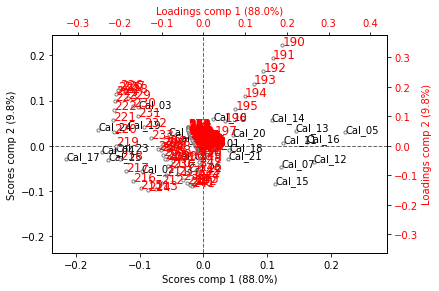

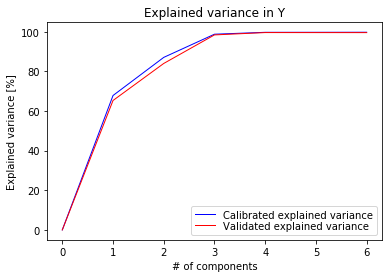

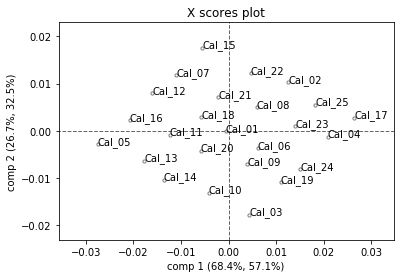

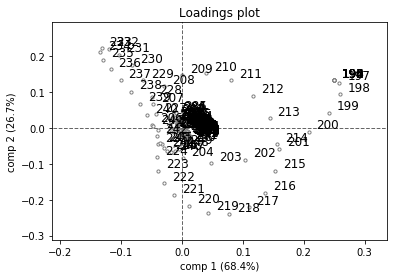

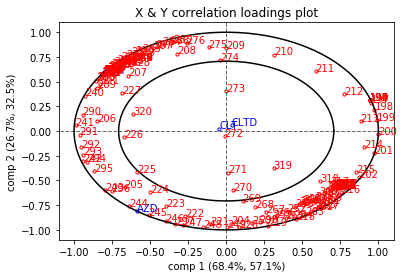

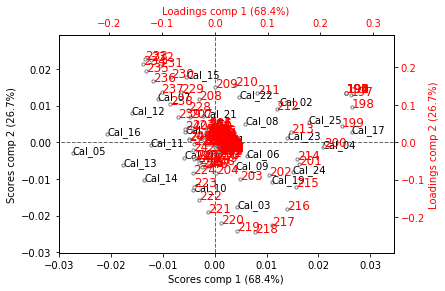

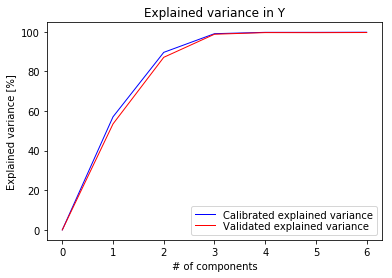

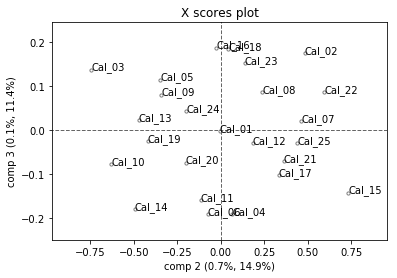

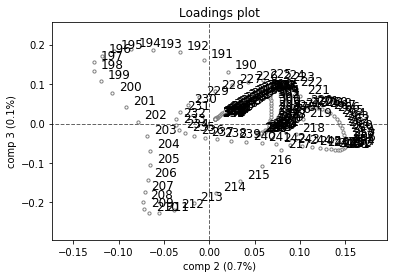

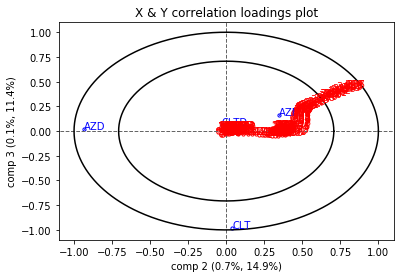

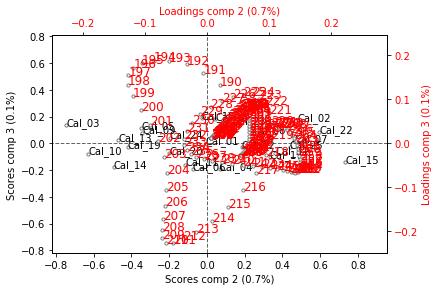

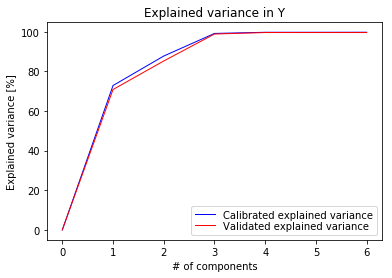

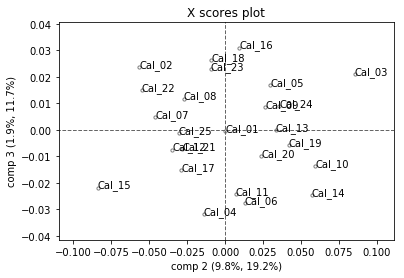

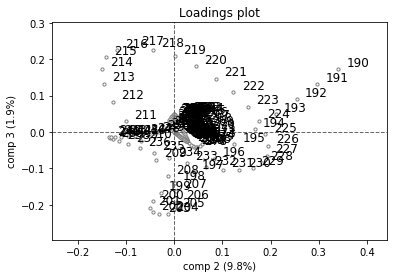

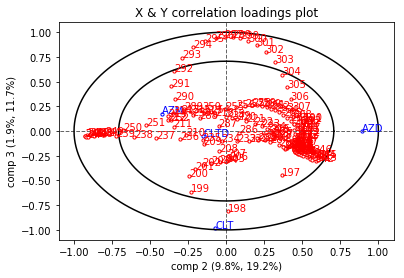

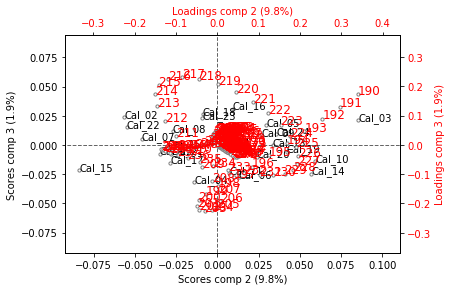

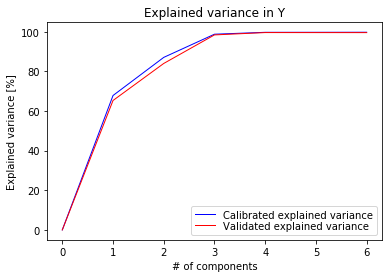

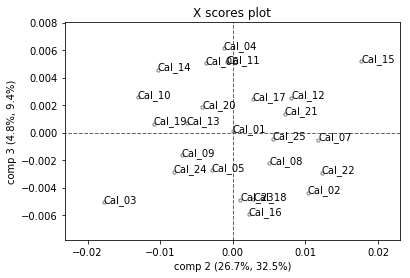

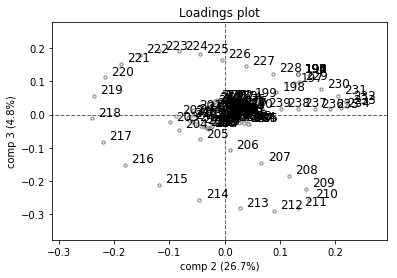

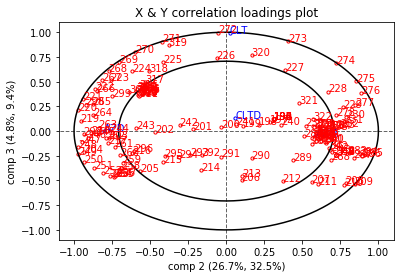

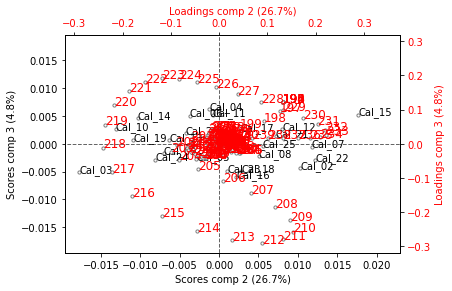

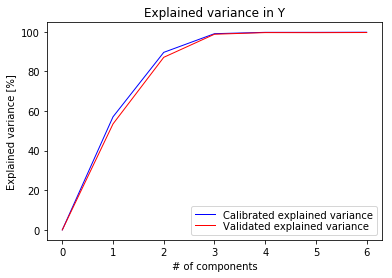

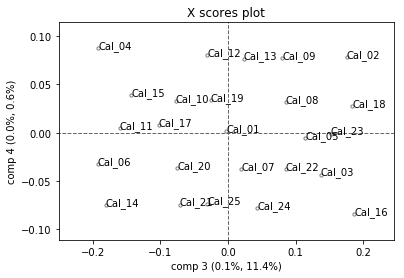

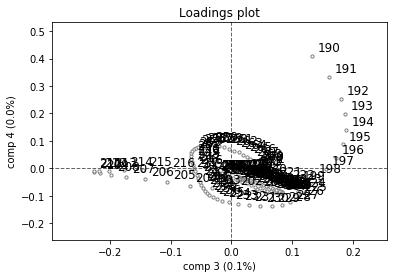

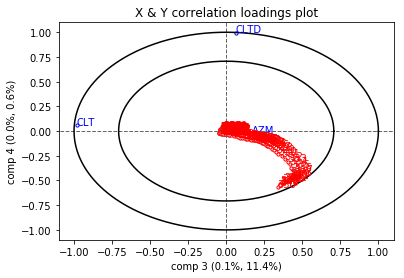

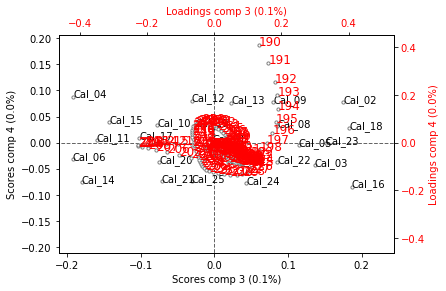

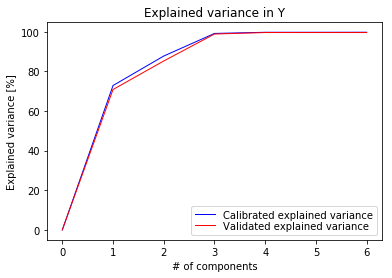

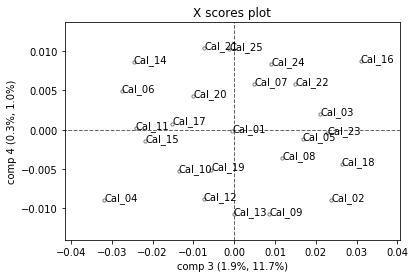

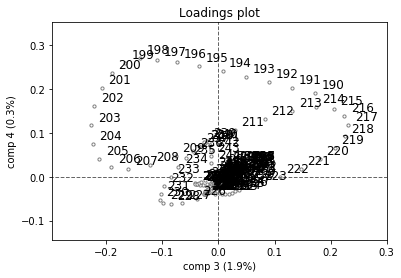

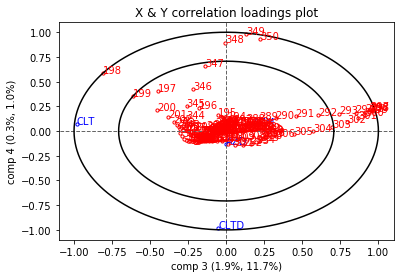

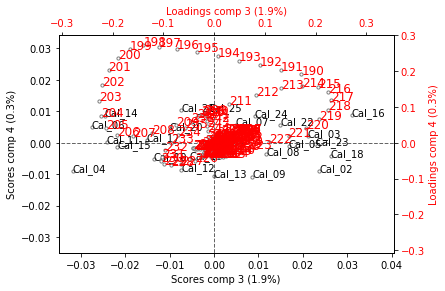

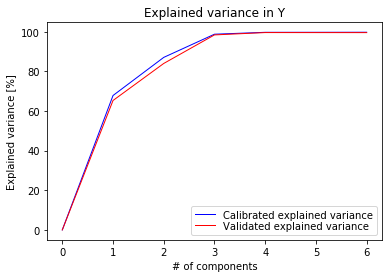

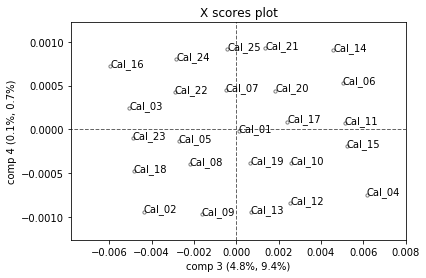

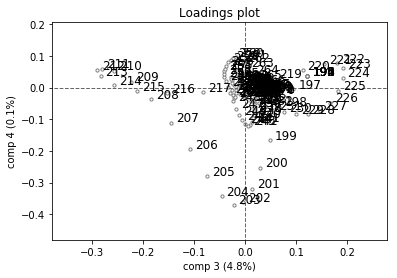

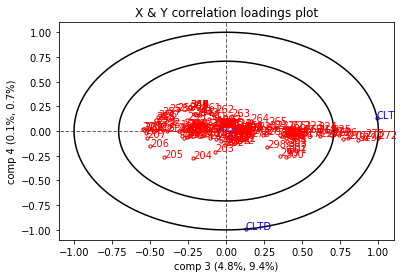

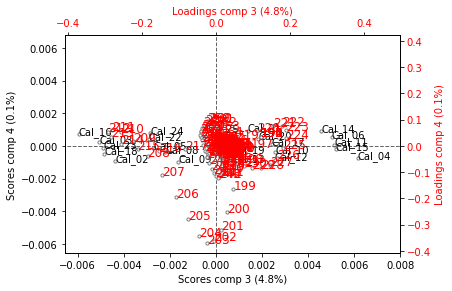

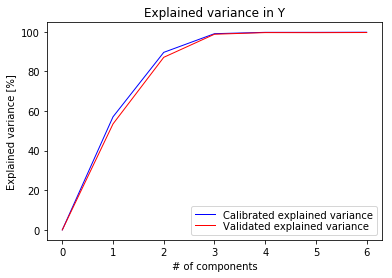

In [20]:
for i in [1,2,3]:
    for j in [modelD0, modelD1, modelD2]:
        hop.plot(j, comp=[i, i+1], plots=[1, 2, 3, 4, 6], objNames=Xsamples, XvarNames=wl,YvarNames=Analytes)

In [10]:
def variable_selection(X, y, max_comp,analyte):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))

    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        model1 = ho.pcr.nipalsPCR(arrX=X, Xstand=False, arrY=y, Ystand=False,cvType=["loo"], numComp=i+1)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(model1.regressionCoefficients(i)[:,analyte]))

        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]

        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            model2 = ho.pcr.nipalsPCR(arrX=Xc[:, j:], Xstand=False, arrY=y, Ystand=False,cvType=["loo"], numComp=i+1)
            loo = ho.cross_val.LeaveOneOut(25)
            for train_index, test_index in loo:
                X_train, X_test, y_train, y_test = cross_val.split(train_index, test_index, Xc[:, j:], y)
                #pred_Y = model2.Y_predict(X_test, numComp=i+1)
                y_cv = model2.Y_predict(Xc[:, j:], numComp=i+1)#cross_val_predict(model2, Xc[:, j:], y, cv=5)
                #np.shape(model2.Y_RMSEE())
                mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))

    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()


    # Calculate PLS with optimal components and export values
    model = ho.pcr.nipalsPCR(arrX=X, Xstand=False, arrY=y, Ystand=False,cvType=["loo"], numComp=mseminx[0]+1)
        
    sorted_ind = np.argsort(np.abs(model.regressionCoefficients(analyte)[:,analyte]))

    Xc = X[:,sorted_ind]

    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [11]:
#for i,j,k,l,m in zip([0,1,2,3],['opt_Xc_AZM','opt_Xc_CLT','opt_Xc_AZD','opt_Xc_CLTD'],
                         #['ncomp_AZM','ncomp_CLT','ncomp_AZD','ncomp_CLTD'],['wav_AZM','wav_CLT','wav_AZD','wav_CLTD'],
                         #['sorted_ind_AZM','sorted_ind_CLT','sorted_ind_AZD','sorted_ind_CLTD']):
opt_Xc_AZMD0, ncomp_AZMD0, wav_AZMD0, sorted_ind_AZMD0= variable_selection(X, y, 6,0)
opt_Xc_CLTD0, ncomp_CLTD0, wav_CLTD0, sorted_ind_CLTD0= variable_selection(X, y, 6,1)
opt_Xc_AZDD0, ncomp_AZDD0, wav_AZDD0, sorted_ind_AZDD0= variable_selection(X, y, 6,2)
opt_Xc_CLTDD0, ncomp_CLTDD0, wav_CLTDD0, sorted_ind_CLTDD0= variable_selection(X, y, 6,3)

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
16% completedloo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
16% completedloo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo

In [12]:
opt_Xc_AZMD1, ncomp_AZMD1, wav_AZMD1, sorted_ind_AZMD1= variable_selection(X1, y, 6,0)
opt_Xc_CLTD1, ncomp_CLTD1, wav_CLTD1, sorted_ind_CLTD1= variable_selection(X1, y, 6,1)
opt_Xc_AZDD1, ncomp_AZDD1, wav_AZDD1, sorted_ind_AZDD1= variable_selection(X1, y, 6,2)
opt_Xc_CLTDD1, ncomp_CLTDD1, wav_CLTDD1, sorted_ind_CLTDD1= variable_selection(X1, y, 6,3)

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
16% completedloo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
16% completedloo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo

In [13]:
opt_Xc_AZMD2, ncomp_AZMD2, wav_AZMD2, sorted_ind_AZMD2= variable_selection(X2, y, 6,0)
opt_Xc_CLTD2, ncomp_CLTD2, wav_CLTD2, sorted_ind_CLTD2= variable_selection(X2, y, 6,1)
opt_Xc_AZDD2, ncomp_AZDD2, wav_AZDD2, sorted_ind_AZDD2= variable_selection(X2, y, 6,2)#gives singular matrix
opt_Xc_CLTDD2, ncomp_CLTDD2, wav_CLTDD2, sorted_ind_CLTDD2= variable_selection(X2, y, 6,3)#gives singular matrix

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
16% completedloo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
16% completedloo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo

LinAlgError: Singular matrix

In [84]:
for i in [opt_Xc_AZMD0, ncomp_AZMD0, wav_AZMD0, sorted_ind_AZMD0,opt_Xc_CLTD0, ncomp_CLTD0, wav_CLTD0, sorted_ind_CLTD0,
         opt_Xc_AZDD0, ncomp_AZDD0, wav_AZDD0, sorted_ind_AZDD0,opt_Xc_CLTDD0, ncomp_CLTDD0, wav_CLTDD0, sorted_ind_CLTDD0,
         opt_Xc_AZMD1, ncomp_AZMD1, wav_AZMD1, sorted_ind_AZMD1,opt_Xc_CLTD1, ncomp_CLTD1, wav_CLTD1, sorted_ind_CLTD1,
         opt_Xc_AZDD1, ncomp_AZDD1, wav_AZDD1, sorted_ind_AZDD1,opt_Xc_CLTDD1, ncomp_CLTDD1, wav_CLTDD1, sorted_ind_CLTDD1,
         opt_Xc_AZMD2, ncomp_AZMD2, wav_AZMD2, sorted_ind_AZMD2,opt_Xc_CLTD2, ncomp_CLTD2, wav_CLTD2, sorted_ind_CLTD2]:
    np.savetxt("{}.csv".format(i), i, delimiter=",")

FileNotFoundError: [Errno 2] No such file or directory: '[[ 0.8313249   0.8149415   0.8008763   0.7894447   0.7807543   0.774002\n   0.7688365   0.4773266  -0.02117334]\n [ 0.7004287   0.6938335   0.6886823   0.68521     0.6831332   0.6818544\n   0.6812906   0.4494361  -0.01803353]\n [ 0.5628656   0.5359454   0.51178     0.4910277   0.4742841   0.460982\n   0.4504761   0.2495168  -0.02035851]\n [ 0.5692087   0.5581597   0.5489618   0.5417036   0.5366463   0.5331569\n   0.5308943   0.3046401  -0.02415521]\n [ 1.159511    1.133885    1.111421    1.092942    1.078315    1.066755\n   1.057702    0.6702814  -0.02470365]\n [ 0.7470081   0.7305237   0.71634     0.7045816   0.695592    0.6886808\n   0.6832778   0.4017433  -0.02149956]\n [ 1.07796     1.066452    1.057118    1.050016    1.044884    1.040924\n   1.037831    0.6754077  -0.0181932 ]\n [ 0.7657751   0.754225    0.7445436   0.7370124   0.7315615   0.7274906\n   0.7245824   0.4629357  -0.01928617]\n [ 0.690395    0.6703837   0.6528848   0.6385126   0.6274085   0.6188572\n   0.6124365   0.3682657  -0.02452653]\n [ 0.7862892   0.7606193   0.7378597   0.7188069   0.7038153   0.6921687\n   0.6831021   0.3933064  -0.02713858]\n [ 1.031985    1.012374    0.9955082   0.9818372   0.9714271   0.9632029\n   0.9569441   0.5877284  -0.02546584]\n [ 1.138682    1.123387    1.110762    1.10106     1.094151    1.088881\n   1.085093    0.6950102  -0.02618451]\n [ 1.018768    0.9936752   0.9716454   0.9536541   0.939567    0.9286994\n   0.9203652   0.5668701  -0.02882476]\n [ 0.9620791   0.9360731   0.9130723   0.8937503   0.8783422   0.8661244\n   0.8563535   0.5051935  -0.02430551]\n [ 1.099593    1.093776    1.089769    1.087628    1.08684     1.086573\n   1.086708    0.7047472  -0.02156607]\n [ 1.085909    1.065245    1.04719     1.032442    1.020625    1.011168\n   1.003588    0.6495672  -0.01773678]\n [ 0.4972259   0.4901548   0.4844106   0.4800225   0.4771622   0.4751923\n   0.4738604   0.2816065  -0.01731266]\n [ 0.8870527   0.870762    0.8566759   0.8454952   0.836821    0.8301513\n   0.8251391   0.5323244  -0.02037639]\n [ 0.5772236   0.5568869   0.5389091   0.5238385   0.5121446   0.5031049\n   0.4961925   0.2783694  -0.02332935]\n [ 0.8835922   0.8632514   0.8455496   0.8308891   0.8194541   0.8104429\n   0.8033707   0.4880462  -0.02201686]\n [ 0.930591    0.9187686   0.9088458   0.9011666   0.8954085   0.8907793\n   0.8871918   0.5629271  -0.01704739]\n [ 0.8420486   0.8348786   0.8292692   0.8253518   0.8226675   0.8206846\n   0.8193014   0.5379499  -0.01446933]\n [ 0.5947737   0.5826218   0.5721608   0.5637066   0.5573431   0.5524035\n   0.5487527   0.346258   -0.01632021]\n [ 0.5180591   0.5005731   0.4850549   0.4718425   0.461367    0.4530341\n   0.4465005   0.2568801  -0.01578411]\n [ 0.6153789   0.6077443   0.601537    0.5967308   0.5932245   0.5906054\n   0.5885519   0.3675374  -0.01331442]].csv'

In [47]:
for i,j,k,l,m in zip([0,1,2,3],['opt_Xc_AZM','opt_Xc_CLT','opt_Xc_AZD','opt_Xc_CLTD'],
                         ['ncomp_AZM','ncomp_CLT','ncomp_AZD','ncomp_CLTD'],['wav_AZM','wav_CLT','wav_AZD','wav_CLTD'],
                         ['sorted_ind_AZM','sorted_ind_CLT','sorted_ind_AZD','sorted_ind_CLTD']):
    j, k, l, m= variable_selection(X, y, 6,i)

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo


loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
16% completedloo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
16% completedloo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo

loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
16% completedloo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo
loo

In [35]:
XX=Dataset.loc['Cal_01':'Cal_25', '190':'350']
Columns_names=np.array(XX.columns)
wl_names=Columns_names[:]
wlplot=list(map(int, wl_names))
wlplot=np.array(wlplot)

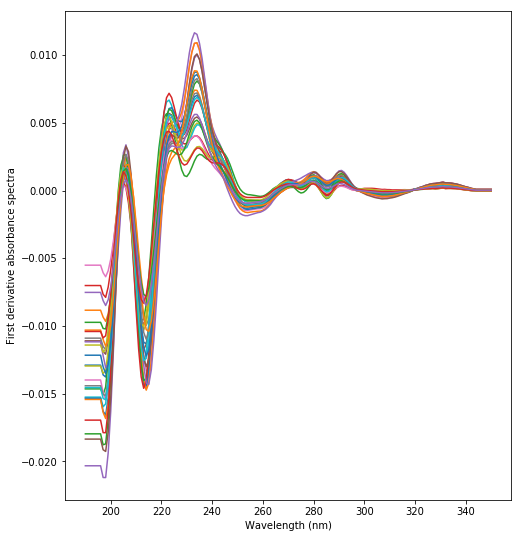

In [86]:
# Get a boolean array according to the indices that are being discarded
ix = np.in1d(wlplot.ravel(), wlplot[sorted_ind_AZMD2][:wav_AZMD2])

import matplotlib.collections as collections

# Plot spectra with superimpose selected bands
fig, ax = plt.subplots(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax.plot(wlplot, X2.T)
    plt.ylabel('First derivative absorbance spectra')
    plt.xlabel('Wavelength (nm)')

collection = collections.BrokenBarHCollection.span_where(wlplot, ymin=-1, ymax=1, where=ix == True, facecolor='red', alpha=0.3)
ax.add_collection(collection)

plt.show()

In [27]:
modelD2_opt_Xc_AZMD2 = ho.pcr.nipalsPCR(arrX=opt_Xc_AZMD2, Xstand=False, arrY=y, Ystand=False,cvType=["loo"], numComp=6)

loo


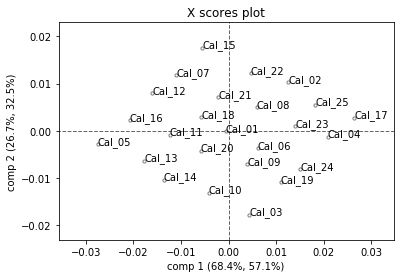

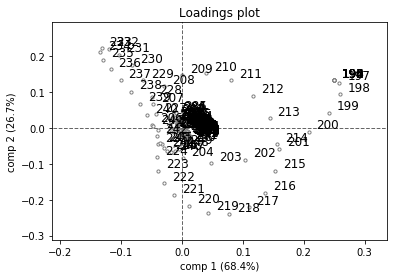

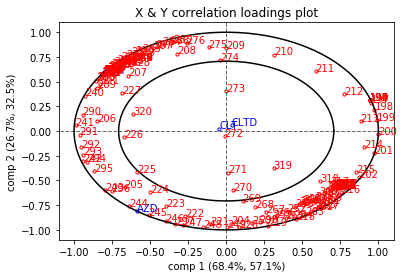

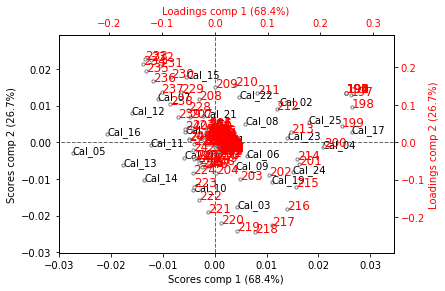

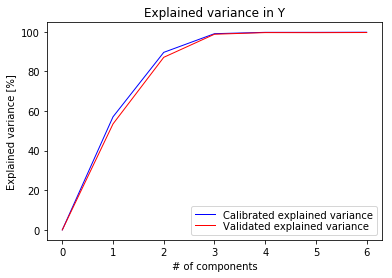

In [33]:
hop.plot(modelD2, comp=[1, 2], plots=[1, 2, 3, 4, 6], objNames=Xsamples, XvarNames=wl,YvarNames=Analytes)

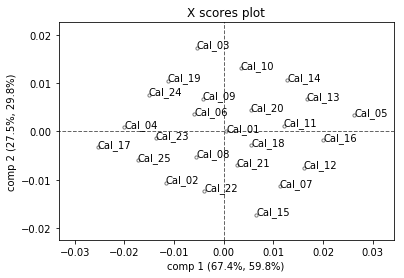

IndexError: index 159 is out of bounds for axis 0 with size 159

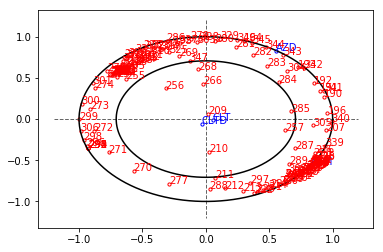

In [35]:
hop.plot(modelD2_opt_Xc_AZMD2, comp=[1, 2], plots=[1, 3, 4, 6], objNames=Xsamples, XvarNames=wl,YvarNames=Analytes)
